# Verkeersdata Analyse Porfolio

In [1]:
# Libraries inladen
import pandas as pd
pd.set_option('display.max_columns', None) # Als er veel kolommen zijn, wil ik ze allemaal zien bij printen
import matplotlib.pyplot as plt

In [2]:
# Datasets inladen
accidents = pd.read_csv("datasets/accident_data.csv")
roads = pd.read_csv("datasets/road_data.csv")
weather = pd.read_csv("datasets/weather_data.csv")

## Datasets mergen aan elkaar

Eerst een kijke nemen op de datasets:

In [3]:
# Overzicht Data
def overzicht(df, name):
    print(f"\n {name} \n")
    print("-------------------------")
    print(df.head())

overzicht(accidents, "Accident Data")
overzicht(weather, "Weather Data")
overzicht(roads, "Road Data")


 Accident Data 

-------------------------
          ID   Source  Severity                     Start_Time  \
0  A-2047758  Source2         2            2019-06-12 10:10:56   
1  A-4694324  Source1         2  2022-12-03 23:37:14.000000000   
2  A-5006183  Source1         2  2022-08-20 13:13:00.000000000   
3  A-4237356  Source1         2            2022-02-21 17:43:04   
4  A-6690583  Source1         2            2020-12-04 01:46:00   

                        End_Time  Start_Lat   Start_Lng    End_Lat  \
0            2019-06-12 10:55:58  30.641211  -91.153481        NaN   
1  2022-12-04 01:56:53.000000000  38.990562  -77.399070  38.990037   
2  2022-08-20 15:22:45.000000000  34.661189 -120.492822  34.661189   
3            2022-02-21 19:43:23  43.680592  -92.993317  43.680574   
4            2020-12-04 04:13:09  35.395484 -118.985176  35.395476   

      End_Lng  Distance(mi)  \
0         NaN         0.000   
1  -77.398282         0.056   
2 -120.492442         0.022   
3  -92.972223 

Accidents en weather data mergen

In [4]:
# Start_Time kolom komt 2 keer voor (bij accidents en weather).
weather.drop(columns=["Start_Time"], inplace=True)

# Mergen op basis van het aantal rijen
merged = pd.concat([accidents, weather], axis=1)

#Controleren
merged.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,City,County,State,Zipcode,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Sunrise_Sunset
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,Accident on LA-19 Baker-Zachary Hwy at Lower Z...,Zachary,East Baton Rouge,LA,70791-4610,2019-06-12 09:53:00,77.0,77.0,62.0,29.92,10.0,NW,5.0,0.0,Fair,Day
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,Incident on FOREST RIDGE DR near PEPPERIDGE PL...,Sterling,Loudoun,VA,20164-2813,2022-12-03 23:52:00,45.0,43.0,48.0,29.91,10.0,W,5.0,0.0,Fair,Night
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.661189,-120.492442,0.022,Accident on W Central Ave from Floradale Ave t...,Lompoc,Santa Barbara,CA,93436,2022-08-20 12:56:00,68.0,68.0,73.0,29.79,10.0,W,13.0,0.0,Fair,Day
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,Incident on I-90 EB near REST AREA Drive with ...,Austin,Mower,MN,55912,2022-02-21 17:35:00,27.0,15.0,86.0,28.49,10.0,ENE,15.0,0.0,Wintry Mix,Day
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,RP ADV THEY LOCATED SUSP VEH OF 20002 - 726 CR...,Bakersfield,Kern,CA,93305-2649,2020-12-04 01:54:00,42.0,42.0,34.0,29.77,10.0,CALM,0.0,0.0,Fair,Night


Accidents en road data mergen

In [5]:
# Omdat ik al een merged data heb zal ik die data gebruiken
df = pd.merge(merged, roads, on='ID', how='left')

#### Kijken of alles goed is gegaan

In [6]:
print(accidents.shape[0])
print(weather.shape[0])
print(roads.shape[0])
print(df.shape[0])

500000
500000
500000
500000


## Onvolledige data verwijderen of aanvullen

In [7]:
# Overzicht Data
print(df)

               ID   Source  Severity                     Start_Time  \
0       A-2047758  Source2         2            2019-06-12 10:10:56   
1       A-4694324  Source1         2  2022-12-03 23:37:14.000000000   
2       A-5006183  Source1         2  2022-08-20 13:13:00.000000000   
3       A-4237356  Source1         2            2022-02-21 17:43:04   
4       A-6690583  Source1         2            2020-12-04 01:46:00   
...           ...      ...       ...                            ...   
499995  A-6077227  Source1         2            2021-12-15 07:30:00   
499996  A-6323243  Source1         2            2021-12-19 16:25:00   
499997  A-3789256  Source1         2            2022-04-13 19:28:29   
499998  A-7030381  Source1         3            2020-05-15 17:20:56   
499999  A-5438901  Source1         2            2022-04-02 23:23:13   

                             End_Time  Start_Lat   Start_Lng    End_Lat  \
0                 2019-06-12 10:55:58  30.641211  -91.153481        NaN 

In [8]:
# Percentage van missende waarden per kolom
print((df.isnull().sum() / len(df) * 100))

ID                    0.0000
Source                0.0000
Severity              0.0000
Start_Time            0.0000
End_Time              0.0000
Start_Lat             0.0000
Start_Lng             0.0000
End_Lat              44.0754
End_Lng              44.0754
Distance(mi)          0.0000
Description           0.0002
City                  0.0038
County                0.0000
State                 0.0000
Zipcode               0.0232
Weather_Timestamp     1.5348
Temperature(F)        2.0932
Wind_Chill(F)        25.8034
Humidity(%)           2.2260
Pressure(in)          1.7856
Visibility(mi)        2.2582
Wind_Direction        2.2394
Wind_Speed(mph)       7.3974
Precipitation(in)    28.5232
Weather_Condition     2.2202
Sunrise_Sunset        0.2966
Amenity               0.0000
Bump                  0.0000
Crossing              0.0000
Give_Way              0.0000
Junction              0.0000
No_Exit               0.0000
Railway               0.0000
Roundabout            0.0000
Station       

In de kolommen End_lat en End_lng zitten ook heel veel missende waardes. Aangezien ik al de coordinaten van de incident locaties heb (Start_Lat - Start_Lng) heb ik deze twee kolommen niet nodig.

In [9]:
# End_Lat en End_Lng kolommen verwijderen met  veel missende waardes (niet nodig)
df.drop(['End_Lat', 'End_Lng'], axis=1, inplace=True)

In de description en city kolommen zitten heel weininig nan waardes, hierbij kunnen we heel makkelijk deze rijen veranderen, want het zal geen effect hebben op de analyse.

In [10]:
# Rijen met nan waardes verwijderen
df.dropna(subset=["Description", "City", "Zipcode"], inplace=True)

In de kolom 'Precipitation(in)' zitten veel missende waarden. Aangezien waarschijnlijk in de meeste geval niet regenen of sneeuwen betekent dat er geen regen of sneeuw is gevallen, besloot ik om de missende waarden met '0.0' te invullen. Zo heb ik geen dataverlies en kan werken met deze kolom.

In [11]:
# None waardes veranderen met 0
df.fillna({"Precipitation(in)": 0.0}, inplace=True)

Als je kijkt naar de Wind_Chill(F) kolom, zie je dat het meestaal heel dichtbij of soms helemaal hetzelfde is met de Temperature(F) kolom. Dit betekent dat de NaN waardes gewoon met de waardes van Temperature(F) opgevuld kan worden. Dit geldt ook voor de kolom Temperature(F).

In [12]:
df[["Wind_Chill(F)","Temperature(F)"]].head()

,Wind_Chill(F),Temperature(F)
0,77.0,77.0
1,43.0,45.0
2,68.0,68.0
3,15.0,27.0
4,42.0,42.0


In [13]:
# Opvullen met dichtstbijzijnde waardes
df.fillna({"Wind_Chill(F)": "Temperature(F)"}, inplace=True)
df.fillna({"Temperature(F)": "Wind_Chill(F)"}, inplace=True)

Omdat de resterende kolommen heel weinig NaN waardes bevatten, kunnen de rijen met de NaN values gelijk werwijderd kan worden. Dit heeft geen effect op de analyse en de data begrijpelijker.

In [14]:
# De rijen met weinig missende waardes verwijderen
df.dropna(subset=["Humidity(%)", "Pressure(in)" 
                       ,"Visibility(mi)", "Wind_Direction", 
                       "Wind_Speed(mph)", "Weather_Condition", "Sunrise_Sunset"], 
               inplace=True)

In [15]:
df.isnull().sum()

ID                   0
Source               0
Severity             0
Start_Time           0
End_Time             0
Start_Lat            0
Start_Lng            0
Distance(mi)         0
Description          0
City                 0
County               0
State                0
Zipcode              0
Weather_Timestamp    0
Temperature(F)       0
Wind_Chill(F)        0
Humidity(%)          0
Pressure(in)         0
Visibility(mi)       0
Wind_Direction       0
Wind_Speed(mph)      0
Precipitation(in)    0
Weather_Condition    0
Sunrise_Sunset       0
Amenity              0
Bump                 0
Crossing             0
Give_Way             0
Junction             0
No_Exit              0
Railway              0
Roundabout           0
Station              0
Stop                 0
Traffic_Calming      0
Traffic_Signal       0
dtype: int64

Alle missende waardes zijn nu verwijderd.

## Onnodige Kolommen verwijderen
Om de data overzichtelijk te houden, onnodig geheugengebruik te voorkomen en alleen met kolommen te werken die relevant zijn voor de analyse, is het handig om een paar overbodige kolommen te verwijderen.

In [16]:
# Accidents kolommen
df.drop(columns=[
    "Description", "Source", "Zipcode", "Distance(mi)"
]
               , inplace=True)

# Weather kolommen
df.drop(columns=[
    "Wind_Chill(F)", "Visibility(mi)", "Wind_Direction", "Weather_Timestamp"	 
]
            , inplace=True)

In [17]:
print(df.columns)

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'City', 'County', 'State', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Wind_Speed(mph)', 'Precipitation(in)',
       'Weather_Condition', 'Sunrise_Sunset', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal'],
      dtype='object')


## Onrealistische waarden filtreren
Uitschieters of fout waardes verwijderen.

In [18]:
# Kijken of er foute waarden tussen zitten
df.describe()

,Severity,Start_Lat,Start_Lng,Humidity(%),Pressure(in),Wind_Speed(mph),Precipitation(in)
count,456837.000000,456837.000000,456837.000000,456837.000000,456837.000000,456837.000000,456837.000000
mean,2.203263,36.189302,-94.602956,64.418826,29.510879,7.686267,0.005813
std,0.479841,5.115759,17.315853,22.771388,1.018250,5.424771,0.064346
min,1.000000,24.562117,-124.497420,1.000000,19.360000,0.000000,0.000000
25%,2.000000,33.336644,-117.165040,48.000000,29.330000,4.600000,0.000000
50%,2.000000,35.825296,-87.697200,67.000000,29.830000,7.000000,0.000000
75%,2.000000,40.115129,-80.374669,84.000000,30.020000,10.400000,0.000000
max,4.000000,48.999569,-67.484130,100.000000,38.440000,822.800000,10.090000


#### Wind-luchtdruk (Pressure)
Winddruk kan niet minder dan 25 of meer dan 32 zijn. Meer informatie kun je [hier](https://www.rovary.com/pages/luchtdruk) vinden. Daarom filtreer ik de waarden in Pressure kolom tussen 25 en 32 inch.

In [19]:
# Waarden filtreren tussen 25 en 32
df = df[(df['Pressure(in)'] >= 25) & (df['Pressure(in)'] <= 32)]

#### Windsnelheid (Wind_speed)
Volgens de [Saffir-Simpson orkaanschaal](https://www.nhc.noaa.gov/aboutsshws.php) beginnen orkanen bij windsnelheden van 74 mph. Zelfs de zwaarste orkanen (categorie 5) hebben windsnelheden van 157 mph of hoger. Dus waarden zoals 822mph zijn fysiek onmogelijk en dus fout. Om het realistisch te houden zal ik de windsnelheid filtreren tot 120 mph.

In [20]:
# Windsnelheid filtreren tot 120 mph
df = df[(df['Wind_Speed(mph)'] <= 120)]

#### Controleren

In [21]:
df.describe()

,Severity,Start_Lat,Start_Lng,Humidity(%),Pressure(in),Wind_Speed(mph),Precipitation(in)
count,450641.000000,450641.000000,450641.000000,450641.000000,450641.000000,450641.000000,450641.000000
mean,2.201968,36.147894,-94.411729,64.567081,29.586739,7.675137,0.005851
std,0.477965,5.131744,17.346012,22.660884,0.782262,5.237449,0.064739
min,1.000000,24.562117,-124.497420,2.000000,25.000000,0.000000,0.000000
25%,2.000000,33.218240,-117.189735,48.000000,29.360000,4.600000,0.000000
50%,2.000000,35.775593,-87.302086,67.000000,29.840000,7.000000,0.000000
75%,2.000000,40.131576,-80.351742,84.000000,30.020000,10.400000,0.000000
max,4.000000,48.999569,-67.484130,100.000000,31.150000,82.000000,10.090000


## Datatypes Corrigeren 
Elke kolom in de datasets moet het juiste datatype hebben, zodat verdere analyses soepel verlopen en foutmeldingen worden voorkomen.

### Accidents

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 450641 entries, 0 to 499999
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ID                 450641 non-null  object 
 1   Severity           450641 non-null  int64  
 2   Start_Time         450641 non-null  object 
 3   End_Time           450641 non-null  object 
 4   Start_Lat          450641 non-null  float64
 5   Start_Lng          450641 non-null  float64
 6   City               450641 non-null  object 
 7   County             450641 non-null  object 
 8   State              450641 non-null  object 
 9   Temperature(F)     450641 non-null  object 
 10  Humidity(%)        450641 non-null  float64
 11  Pressure(in)       450641 non-null  float64
 12  Wind_Speed(mph)    450641 non-null  float64
 13  Precipitation(in)  450641 non-null  float64
 14  Weather_Condition  450641 non-null  object 
 15  Sunrise_Sunset     450641 non-null  object 
 16  Amenity

In [23]:
# City, COuntry en State zijn ook string type kolommen
df[['City', 'County', 'State']] = df[['City', 'County', 'State']].astype('string')

# Om datatypes te veranderen, moeten de nanoseconden in deze kolommen verwijderd worden
df['Start_Time'] = df['Start_Time'].str.extract(r'^(.{19})')[0]
df['End_Time'] = df['End_Time'].str.extract(r'^(.{19})')[0]

# Start_Time en End_Time moeten worden omgezet naar datetime
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['End_Time'] = pd.to_datetime(df['End_Time'])

# Temperature moet float worden
df['Temperature(F)'] = pd.to_numeric(df['Temperature(F)'], errors='coerce')

# Weather_Condition en Sunrise_Sunset zijn ook strings
df[['Sunrise_Sunset', 'Weather_Condition']] = df[['Sunrise_Sunset', 'Weather_Condition']].astype('string')

### Laatste check

In [24]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 450641 entries, 0 to 499999
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ID                 450641 non-null  object        
 1   Severity           450641 non-null  int64         
 2   Start_Time         450641 non-null  datetime64[ns]
 3   End_Time           450641 non-null  datetime64[ns]
 4   Start_Lat          450641 non-null  float64       
 5   Start_Lng          450641 non-null  float64       
 6   City               450641 non-null  string        
 7   County             450641 non-null  string        
 8   State              450641 non-null  string        
 9   Temperature(F)     450641 non-null  float64       
 10  Humidity(%)        450641 non-null  float64       
 11  Pressure(in)       450641 non-null  float64       
 12  Wind_Speed(mph)    450641 non-null  float64       
 13  Precipitation(in)  450641 non-null  float64      

Alles ziet er goed uit

## Aantal ongevallen per tijdstippen
In deze stap analyseer ik op **welke dagen** en in **welke maanden** de meeste verkeersongevallen plaatsvinden.

We gebruiken hiervoor de `Start_Time` kolom in de dataset. Hieruit maak ik 2 nieuwe kolommen aan:
- de **naam van de dag** (zoals maandag, dinsdag)  
- de **naam van de maand** (zoals januari, februari)

Daarna visualiseer ik de spreiding van ongevallen over de week en het jaar. Deze inzichten helpen ons om **drukke dagen** en **seizoensgebonden patronen** te herkennen.

In [25]:
# Nieuwe kolommen maken uit Start_Time 
df['Dag'] = df['Start_Time'].dt.day_name()
df['Maand'] = df['Start_Time'].dt.month_name()

# Controleren
df.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,City,County,State,Temperature(F),Humidity(%),Pressure(in),Wind_Speed(mph),Precipitation(in),Weather_Condition,Sunrise_Sunset,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Dag,Maand
0,A-2047758,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,Zachary,East Baton Rouge,LA,77.0,62.0,29.92,5.0,0.0,Fair,Day,False,False,False,False,False,False,False,False,False,False,False,True,Wednesday,June
1,A-4694324,2,2022-12-03 23:37:14,2022-12-04 01:56:53,38.990562,-77.399070,Sterling,Loudoun,VA,45.0,48.0,29.91,5.0,0.0,Fair,Night,False,False,False,False,False,False,False,False,False,False,False,False,Saturday,December
2,A-5006183,2,2022-08-20 13:13:00,2022-08-20 15:22:45,34.661189,-120.492822,Lompoc,Santa Barbara,CA,68.0,73.0,29.79,13.0,0.0,Fair,Day,False,False,False,False,False,False,False,False,False,False,False,True,Saturday,August
3,A-4237356,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,Austin,Mower,MN,27.0,86.0,28.49,15.0,0.0,Wintry Mix,Day,False,False,False,False,False,False,False,False,False,False,False,False,Monday,February
4,A-6690583,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,Bakersfield,Kern,CA,42.0,34.0,29.77,0.0,0.0,Fair,Night,False,False,False,False,False,False,False,False,False,False,False,False,Friday,December


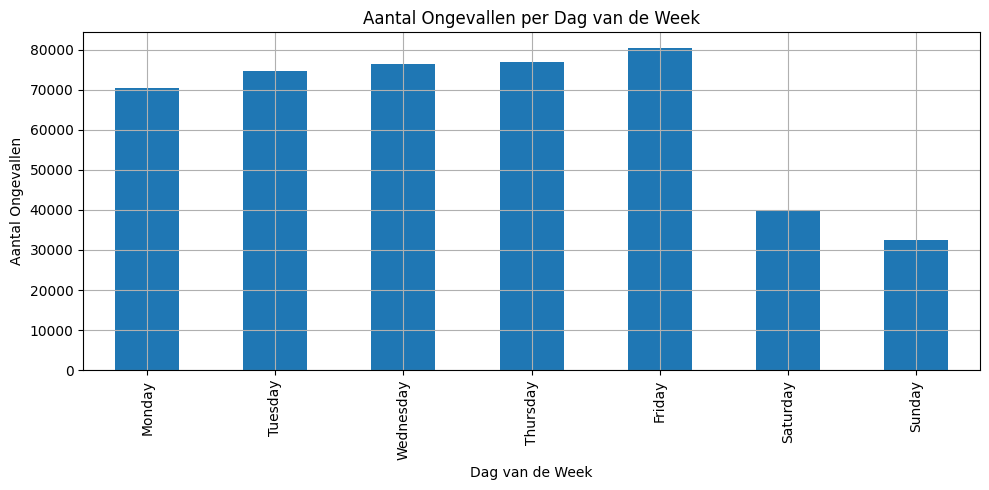

In [26]:
# Ongevallen per dag van de week
plt.figure(figsize=(10, 5))
df['Dag'].value_counts().loc[
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].plot(kind='bar')
plt.title("Aantal Ongevallen per Dag van de Week")
plt.xlabel("Dag van de Week")
plt.ylabel("Aantal Ongevallen")
plt.grid(True)
plt.tight_layout()
plt.show()

De meeste verkeersongevallen vinden plaats op vrijdag, gevolgd door donderdag en woensdag. Dit patroon wijst erop dat ongevallen frequenter zijn aan het einde van de werkweek. Mogelijke verklaringen hiervoor zijn:

	•	Meer verkeer op vrijdag vanwege mensen die eerder naar huis willen of op reis gaan voor het weekend.
	•	Vermoeidheid en stress na een drukke werkweek kunnen bijdragen aan verminderde concentratie op de weg.
	•	Zaterdag en zondag laten aanzienlijk minder ongevallen zien, wat logisch is gezien de lagere verkeersdrukte in het weekend.

Deze inzichten kunnen nuttig zijn bij het plannen van verkeersmaatregelen of voorlichting, vooral gericht op de risicovolle werkdagen.

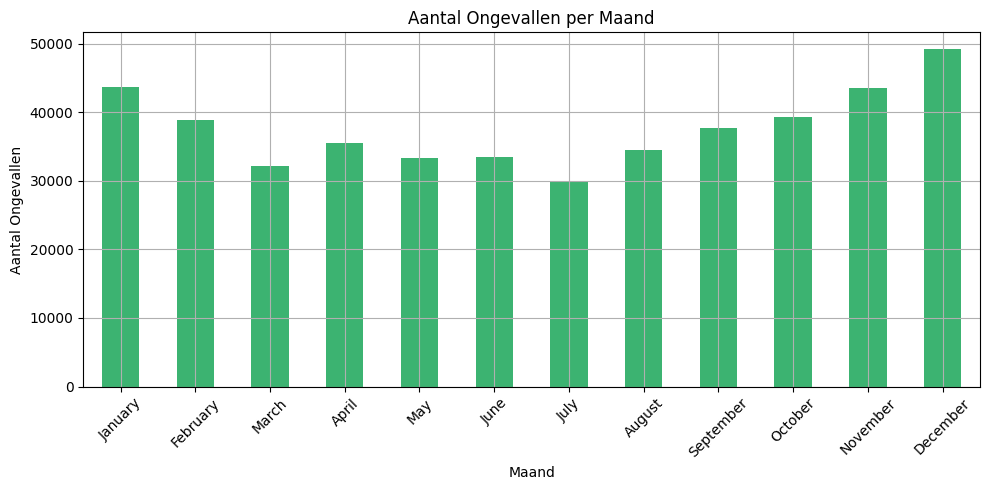

In [27]:
# Ongevallen per maand
plt.figure(figsize=(10, 5))
df['Maand'].value_counts().loc[
    ['January','February','March','April','May','June','July','August','September','October','November','December']
].plot(kind='bar', color='mediumseagreen')
plt.title("Aantal Ongevallen per Maand")
plt.xlabel("Maand")
plt.ylabel("Aantal Ongevallen")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Het hoogste aantal ongevallen vindt plaats in december, gevolgd door januari en november.In de zomermaanden (zoals juli en augustus) ligt het aantal ongevallen juist relatief laag. Mogelijke verklaringen:

	•	Wintermaanden brengen slechtere weersomstandigheden zoals sneeuw, regen en gladheid.
	•	December heeft extra verkeer door feestdagen en drukte op de wegen.
	•	In de zomer zijn er vakanties en minder woon-werkverkeer, wat mogelijk leidt tot minder incidenten.

Dit inzicht toont aan dat seizoen en weersomstandigheden een duidelijke invloed hebben op verkeersveiligheid.